In [1]:
#Plank 2018
cosmology = {'10^9 As':2.09681,
            'ns': 0.9652,
            'H0': 67.37,
            'w0': -1,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'nu_mass_ev': 0.07071068,
            'sigma8': 0.8101,
            }

In [2]:
h = cosmology['H0']/100

In [3]:
import numpy as np

In [4]:
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3


def M_to_R(M, a):
    return (M / (4/3 * np.pi * rhom_a(a))) ** (1/3) # h^-1 Mpc  


def rhom_a(a):
    ombh2 = cosmology['ombh2']
    omch2 = cosmology['omch2']
    H0 = cosmology['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2

    ΩDE = 1 - Ωm
    wDE = cosmology['w0'] #'wa' is zero for us

    return Ωm*ρcrit0#*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE))) * a**3 # h^2 Msol/Mpc^3


In [5]:
a=1.0
M_numerics = np.logspace(11,17,100) 
R = M_to_R(M_numerics, a) #h^-1 Mpc


In [6]:
h = cosmology['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': cosmology['ombh2'] / h**2,
    'Omega_cdm': cosmology['omch2'] / h**2,
    'N_ur': 0.00641,
    'N_ncdm': 1,
    'output': 'mPk mTk',
    'z_pk': '0.0,99',
    'P_k_max_h/Mpc': 20.,
    'm_ncdm': cosmology['nu_mass_ev']/3,
    'deg_ncdm': 3,
    'T_cmb': 2.7255,
    'A_s': cosmology['10^9 As'] * 10**-9,
    'n_s': cosmology['ns'],
    'Omega_Lambda': 0.0,
    'w0_fld': cosmology['w0'],
    'wa_fld': 0.0,
    'cs2_fld': 1.0,
    'fluid_equation_of_state': "CLP"
}


In [7]:
from classy import Class

In [8]:
pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()

In [9]:
z = 1/a - 1
kt = np.logspace(-3, 1, 100)
pk_m_lin = np.array(
    [
        pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
        for ki in kt * h # 1 / Mpc
    ]
)


In [10]:
sigma = [pkclass.sigma(R_curr, z) for R_curr in R]
sigma2s = np.square(sigma)

In [11]:
logsigma = np.log(sigma)
logM = np.log(M_numerics)

In [12]:
from scipy.interpolate import UnivariateSpline

In [13]:
flogsigma_logm = UnivariateSpline(logM, logsigma, s=0)

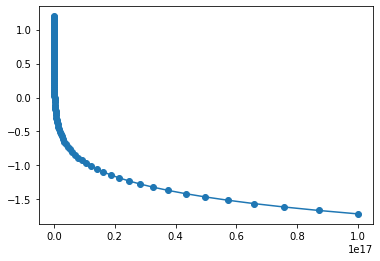

In [14]:
import matplotlib.pyplot as plt

plt.plot(M_numerics, flogsigma_logm(logM))
plt.scatter(M_numerics, logsigma)

In [15]:
# Get the first derivative of the spline
fdlogsigma_dlogm = flogsigma_logm.derivative()
fdlogsigmainv_dm = lambda m: -1/m * fdlogsigma_dlogm(np.log(m)) 

In [16]:
from scipy.interpolate import interp1d
#given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)

In [17]:
def dRdM(M, a):
    return 1/(6**(2/3)*np.pi**(1/3)*M**(2/3)*rhom_a(a)**(1/3))

In [18]:
from utils import *
ds2dR = dsigma2dR(Pk, R)
dRdMs = dRdM(M_numerics, a)
ds2dM = ds2dR * dRdMs

dlnsinvds2 = -1/(2*sigma2s)
dlnsinvdM = ds2dM*dlnsinvds2

f_dlnsinvdM_log = interp1d(np.log10(M_numerics), dlnsinvdM, kind='linear')
f_dlnsinvdM_orig = lambda x: f_dlnsinvdM_log(np.log10(x))

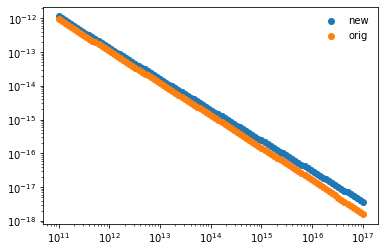

In [19]:
plt.scatter(M_numerics, fdlogsigmainv_dm(M_numerics), label='new')

plt.scatter(M_numerics, f_dlnsinvdM_orig(M_numerics), label='orig')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)

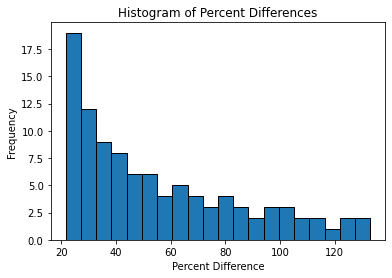

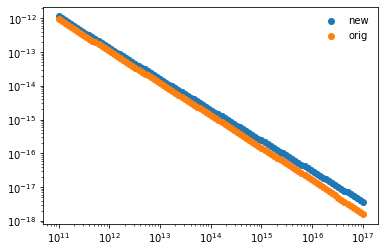

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming fdlogsigmainv_dm and f_dlnsinvdM_orig are your functions
new_values = fdlogsigmainv_dm(M_numerics)
orig_values = f_dlnsinvdM_orig(M_numerics)

# Calculate the percent difference
percent_difference = 100 * (new_values - orig_values) / orig_values

# Plot the histogram
plt.hist(percent_difference, bins=20, edgecolor='black') # You can adjust the number of bins as needed
plt.xlabel('Percent Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Percent Differences')
plt.show()

# Your original scatter plot
plt.scatter(M_numerics, new_values, label='new')
plt.scatter(M_numerics, orig_values, label='orig')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.show()


In [21]:
#I think theyd both work?